# ​Predict Future Sales - Kaggle Challenge

In [1]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import iqr
from pandas.api.types import CategoricalDtype
from googletrans import Translator
import googletrans
import random
import warnings
from xgboost import XGBRegressor
import time
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
warnings.filterwarnings('ignore')

In [2]:
# get the given dataset
items_categories = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
sales_train = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')

## Part 1 - Data Cleaning and Merging

Find if there is any NULL or NAN values in any of the dataframes in the given Dataset.

We can observe that there is no nan or null values in the given dataset

In [3]:
# printing the number of null values in each column in each of the dataframe
print(sales_train.isnull().sum())
print(items.isnull().sum())
print(items_categories.isnull().sum())
print(shops.isnull().sum())

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
item_name           0
item_id             0
item_category_id    0
dtype: int64
item_category_name    0
item_category_id      0
dtype: int64
shop_name    0
shop_id      0
dtype: int64


Drop the duplicate rows present in the dataset. The drop duplicates keeps only one copy of the rows which are entirely the same.

In [4]:
# drop duplicates
shops.drop_duplicates(inplace=True)
sales_train.drop_duplicates(inplace=True)
items.drop_duplicates(inplace=True)
items_categories.drop_duplicates(inplace=True)

Translate the item_category_name column of the item_categories dataframe from Russian to English 

In [5]:
#translate
translator = Translator()
items_categories['item_category_name'] = items_categories['item_category_name'].apply(translator.translate, src='ru', dest='en')
items_categories['item_category_name'] = items_categories['item_category_name'].apply(getattr, args=('text',))

Translate the shop_name column of the shops dataframe from Russian to English 

In [6]:
#translate
shops.drop_duplicates(subset=['shop_name'])
translator = Translator()
shops['shop_name'] = shops['shop_name'].apply(translator.translate, src='ru', dest='en')
shops['shop_name'] = shops['shop_name'].apply(getattr, args=('text',))
shops

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 francs",0
1,"! Yakutsk TC ""Central"" fran",1
2,"Adygea shopping center ""Mega""",2
3,"Balashikha TRK ""October-Kinomir""",3
4,"Volzhsky shopping center ""Volga Mall""",4
5,"Vologda SEC ""Marmelad""",5
6,"Voronezh (Plekhanovskaya, 13)",6
7,"Voronezh SEC ""Maksimir""",7
8,"Voronezh SEC City-Park ""Grad""",8
9,Offsite Trade,9


Only one row has a negative item price. As the price cannot be negative, we replace it with the average item_price of the items from the same shop, sold in the same month.
After replacing the negative value with the mean of the item_price, we see no item_price which is below zero in he result below.  

In [7]:
# Replace negatuve item price with mean value in that column
negative_price = sales_train[sales_train['item_price']<0] 
neg_shop_id = negative_price['shop_id'].values[0]
neg_item_id = negative_price['item_id'].values[0]
neg_date_block = negative_price['date_block_num'].values[0]
mean = sales_train[(sales_train['item_price']>0) & (sales_train['shop_id']==neg_shop_id) & (sales_train['item_id'] == neg_item_id) & (sales_train['date_block_num']==neg_date_block)]['item_price'].mean()
sales_train.loc[sales_train['item_price']<0,'item_price'] = mean
sales_train[sales_train['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


Find the outliers in the column item_price and item_cnt_day. We find the outlier with the help of a boxplot. Visualizing the distribution of the values of both the item_price and item_cnt_day, we can see that there are two outliers in the item_cnt_day and only one outlier in the item_price column. We remove the outliers from both the columns. There cannot be outliers in any other column in the dataset.

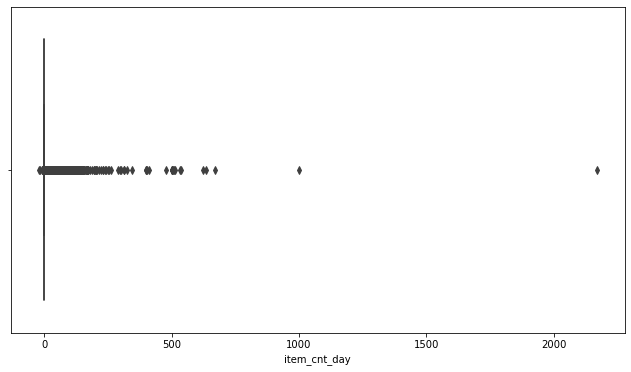

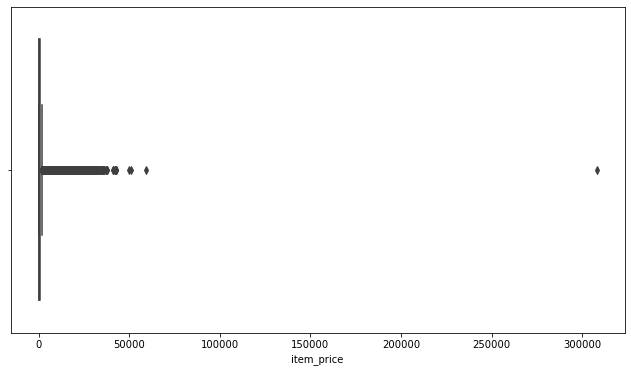

In [8]:
# Plotting the outliers 
plt.figure(figsize=(11,6))
sns.boxplot(sales_train['item_cnt_day'])

plt.figure(figsize=(11,6))
sns.boxplot(sales_train['item_price'])

sales_train = sales_train[sales_train['item_cnt_day']<1000]
sales_train = sales_train[sales_train['item_price']<80000]

After cleaning the dataset, merge all the dataframes into one final dataframe. 

In [9]:
# merging all the dataframes
final_items = items.merge(items_categories,on = 'item_category_id',how = 'inner')
final_sales_train = sales_train.merge(final_items,on='item_id',how='inner')
final_sales_train = final_sales_train.merge(shops,on='shop_id',how='inner')
final_sales_train['date'] = pd.to_datetime(final_sales_train['date'],format='%d.%m.%Y') 
final_sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,2013-01-02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl TC ""Altair"""
1,2013-05-16,4,59,2573,249.0,1.0,DEL REY LANA Born To Die,55,Music - locally produced CD,"Yaroslavl TC ""Altair"""
2,2013-01-26,0,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Music - locally produced CD,"Yaroslavl TC ""Altair"""
3,2013-01-09,0,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Music - locally produced CD,"Yaroslavl TC ""Altair"""
4,2013-02-24,1,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Music - locally produced CD,"Yaroslavl TC ""Altair"""
...,...,...,...,...,...,...,...,...,...,...
2935835,2015-10-28,33,55,1819,1499.0,3.0,"Batman: Рыцарь Аркхема. Premium Edition [PC, Ц...",31,PC Games - Number,Digital warehouse 1C-Online
2935836,2015-10-29,33,55,1819,1499.0,1.0,"Batman: Рыцарь Аркхема. Premium Edition [PC, Ц...",31,PC Games - Number,Digital warehouse 1C-Online
2935837,2015-10-24,33,55,2390,99.0,1.0,"Cold War [PC, Цифровая версия]",31,PC Games - Number,Digital warehouse 1C-Online
2935838,2015-10-01,33,55,1935,249.0,1.0,"BioShock 2. Minerva's Den (дополнение) [PC, Ци...",31,PC Games - Number,Digital warehouse 1C-Online


As a part of cleaning and merging, the following steps were followed,
1. Checking for Null values
2. Dropping the duplicate rows in the dataframes
3. Translating few columns from russian to english.
4. Imputing values of the column item_price which is negative.
5. Finding the outliers.

## Part 2 - Time Series Analysis

In [10]:
# TODO: code for time series analysis
# create new columns
final_sales_train['date'] = pd.to_datetime(final_sales_train['date'],format='%d.%m.%Y') 
final_sales_train['day'] = final_sales_train['date'].dt.day_name()

In [11]:
final_sales_train.loc[final_sales_train['date']>'31/10/2015']

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,day


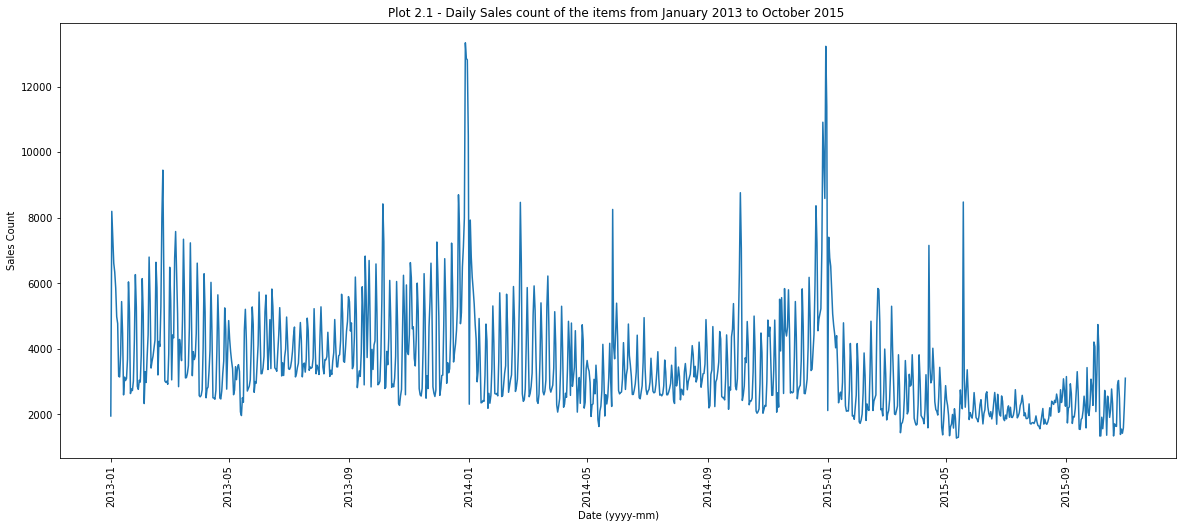

In [12]:
# plot daily sales count each day
sales_each_day = final_sales_train.groupby('date')['item_cnt_day'].sum().reset_index()
plt.figure(figsize= (20,8))
plt.plot(sales_each_day['date'],sales_each_day['item_cnt_day'])
plt.title('Plot 2.1 - Daily Sales count of the items from January 2013 to October 2015 ')
plt.xticks(rotation='vertical')
plt.xlabel('Date (yyyy-mm)')
plt.ylabel('Sales Count')
plt.show()

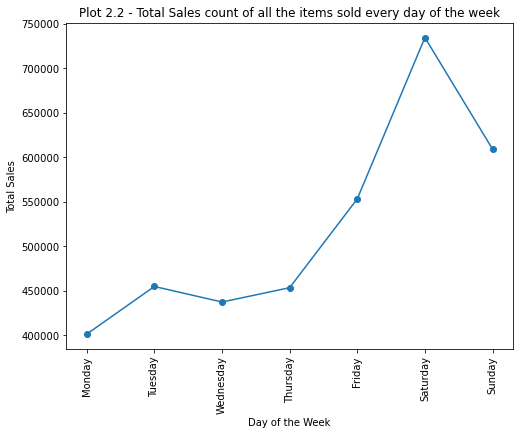

In [13]:

sorter_day = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_each_day = final_sales_train.groupby('day')['item_cnt_day'].sum().reset_index()
sorterIndex = dict(zip(sorter_day,range(len(sorter_day))))
sales_each_day['day_id'] = sales_each_day['day']
sales_each_day['day_id'] = sales_each_day['day_id'].map(sorterIndex)
sales_each_day.sort_values('day_id', inplace=True)
plt.figure(figsize= (8,6))
plt.plot(sales_each_day['day'],sales_each_day['item_cnt_day'],marker='o')
plt.title('Plot 2.2 - Total Sales count of all the items sold every day of the week')
plt.xticks(rotation='vertical')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.show()

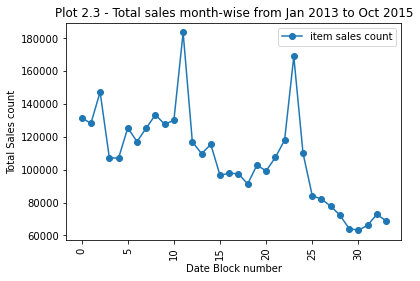

In [14]:
sorter_month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sales_each_month = final_sales_train.groupby('date_block_num')['item_cnt_day'].sum().reset_index()
sales_each_month['month'] = sales_each_month['date_block_num'].apply(lambda x: sorter_month[x%12])
plt.figure()
plt.plot(sales_each_month['date_block_num'],sales_each_month['item_cnt_day'],label='item sales count',marker='o')
plt.title('Plot 2.3 - Total sales month-wise from Jan 2013 to Oct 2015')
plt.legend(loc='upper right')
plt.xticks(rotation='vertical')
plt.xlabel('Date Block number')
plt.ylabel('Total Sales count')
plt.show()

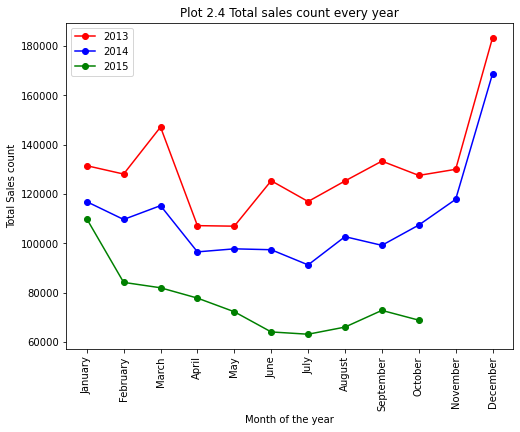

In [15]:
sorter_month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
final_sales_train['month'] = final_sales_train['date'].apply(lambda x:x.strftime('%B'))
year2013 = final_sales_train[final_sales_train['date_block_num']<12]
year2014 = final_sales_train[(final_sales_train['date_block_num']>=12) & (final_sales_train['date_block_num']<24)]
year2015 = final_sales_train[final_sales_train['date_block_num']>=24]

sorterIndex = dict(zip(sorter_month,range(len(sorter_month))))

sales_each_month_2013 = year2013.groupby('month')['item_cnt_day'].sum().reset_index()
sales_each_month_2013['month_id'] = sales_each_month_2013['month'].apply(lambda x: sorter_month.index(x))
sales_each_month_2013 = sales_each_month_2013.sort_values('month_id')

sales_each_month_2014 = year2014.groupby('month')['item_cnt_day'].sum().reset_index()
sales_each_month_2014['month_id'] = sales_each_month_2014['month'].apply(lambda x: sorter_month.index(x))
sales_each_month_2014 = sales_each_month_2014.sort_values('month_id')

sales_each_month_2015 = year2015.groupby('month')['item_cnt_day'].sum().reset_index()
sales_each_month_2015['month_id'] = sales_each_month_2015['month'].apply(lambda x: sorter_month.index(x))
sales_each_month_2015 = sales_each_month_2015.sort_values('month_id')

plt.figure(figsize= (8,6))
plt.plot(sales_each_month_2013['month'],sales_each_month_2013['item_cnt_day'],color='r',label=2013,marker='o')
plt.plot(sales_each_month_2014['month'],sales_each_month_2014['item_cnt_day'],color='b',label=2014,marker='o')
plt.plot(sales_each_month_2015['month'],sales_each_month_2015['item_cnt_day'],color='g',label=2015,marker='o')
plt.title('Plot 2.4 Total sales count every year')
plt.legend(loc='upper left')
plt.xticks(rotation='vertical')
plt.xlabel('Month of the year')
plt.ylabel('Total Sales count')
plt.show()



Observations from Plot 2.1
- It is observed that the total sales count per day reaches maximum in the month of november and december of every year. 
- The total sales per day count trend is decreasing every year starting from 2013. The total sales per day count of a day in 2014 is less than the total sales per day count of the same day in 2013. 
- The sales count per day occasionally increased during a day in the month of March and September in the year 2013, March, June and October in the year 2014, April and June in the year 2015.

Observations from Plot 2.2
- The total sales count is maximum on Saturdays and followed by sunday with second maximum sales considering the total sales from January 2013 to October 2015.
- The total sales count is minimum on Mondays and gradually increases as the week passes on.

Observations from Plot 2.3
- The total sales count per month is maximum in the month of December in the year 2013 and 2014.
- The total sales count per month decreases gradually at the start of the year and gradually increases at the end of the year.

Observations from Plot 2.4
- It is clearly evident that the total sales per month in a year is less than the total sales per month the previous year. This shows that overall sales per month is decreasing every year.

## Part 3 - More Time Series Analysis

The column item_category_name has already been translated in Part 1

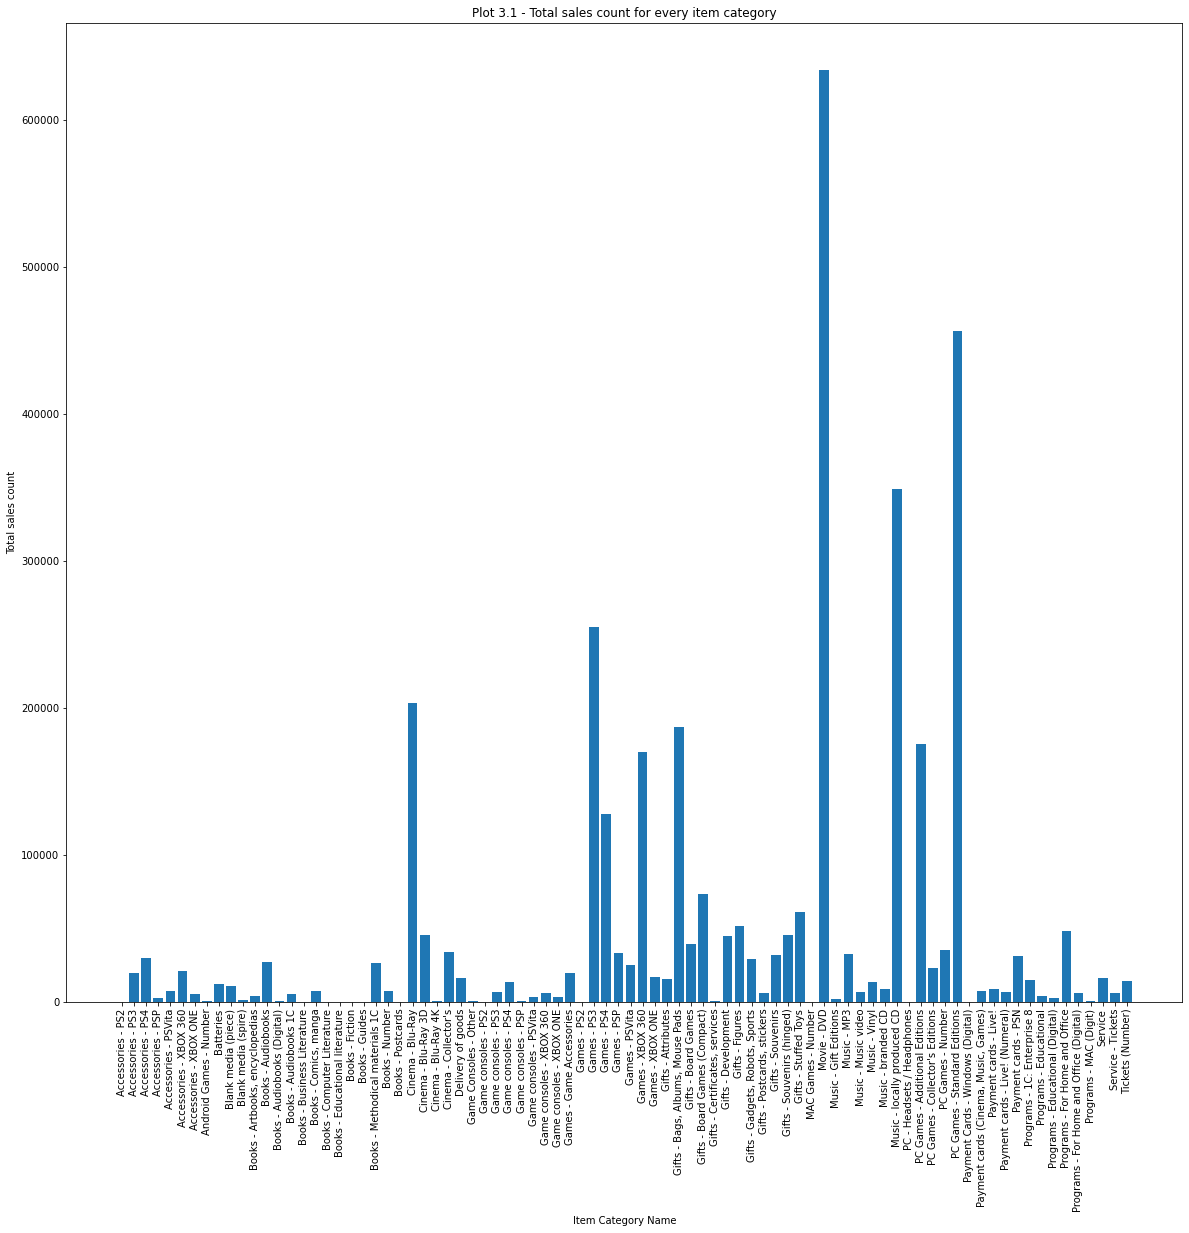

In [16]:
# TODO: code for time series analysis
sales_per_category = final_sales_train.groupby(by = ['item_category_name'])['item_cnt_day'].sum().reset_index()
plt.figure(figsize=(20,18))
plt.bar(sales_per_category['item_category_name'],sales_per_category['item_cnt_day'])
plt.xlabel('Item Category Name')
plt.ylabel('Total sales count')
plt.xticks(rotation='vertical')
plt.title('Plot 3.1 - Total sales count for every item category')
plt.show()

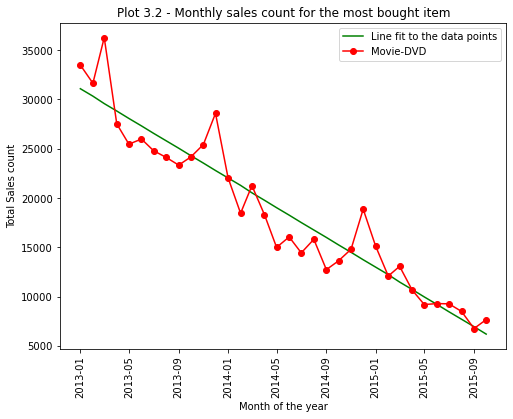

The slope of the negative trend in the total sales count is : -753.9541634835756
The mean sales count of the most bought item is :18652.058823529413
The variance of the sales count of the most bought item is :62473095.39037433


In [17]:
def calculate_monthly_sale_across_years(df,column):
    df['year'] = pd.DatetimeIndex(df['date']).year
    sales_each_month = df.groupby(by=['month','year'])[column].sum().reset_index()
    sales_each_month['date'] = pd.to_datetime(sales_each_month['year'].astype(str)  + sales_each_month['month'], format='%Y%B')
    sales_each_month_sorted = sales_each_month.sort_values('date')
    return sales_each_month_sorted

most_bought = final_sales_train[final_sales_train['item_category_name']=='Movie - DVD']
sales_each_month_mb = calculate_monthly_sale_across_years(most_bought,'item_cnt_day')
coeffs, res, _, _, _ = np.polyfit(range(len(sales_each_month_mb['item_cnt_day'].index)),sales_each_month_mb['item_cnt_day'],1,full=True)
plt.figure(figsize= (8,6))
plt.plot(sales_each_month_mb['date'],[coeffs[0]*x + coeffs[1] for x in range(len(sales_each_month_mb['item_cnt_day'].index))],color='g',label='Line fit to the data points')
plt.plot(sales_each_month_mb['date'],sales_each_month_mb['item_cnt_day'],color='r',label='Movie-DVD',marker='o')
plt.title('Plot 3.2 - Monthly sales count for the most bought item')
plt.legend(loc='upper right')
plt.xticks(rotation='vertical')
plt.xlabel('Month of the year')
plt.ylabel('Total Sales count')
plt.show()

print('The slope of the negative trend in the total sales count is :',str(coeffs[0]))
print('The mean sales count of the most bought item is :' +str(sales_each_month_mb['item_cnt_day'].mean()))
print('The variance of the sales count of the most bought item is :'+str(sales_each_month_mb['item_cnt_day'].var()))

The slope of the trend for the total sales count for Movie - DVD is : -753.9541634835756
The slope of the trend for the total sales count for PC Games - Standard Editions is : -511.8988540870898
The slope of the trend for the total sales count for Music - locally produced CD is : -231.8925897631783
The slope of the trend for the total sales count for Games - PS3 is : -272.96883116883134
The slope of the trend for the total sales count for Cinema - Blu-Ray is : -115.88831168831183


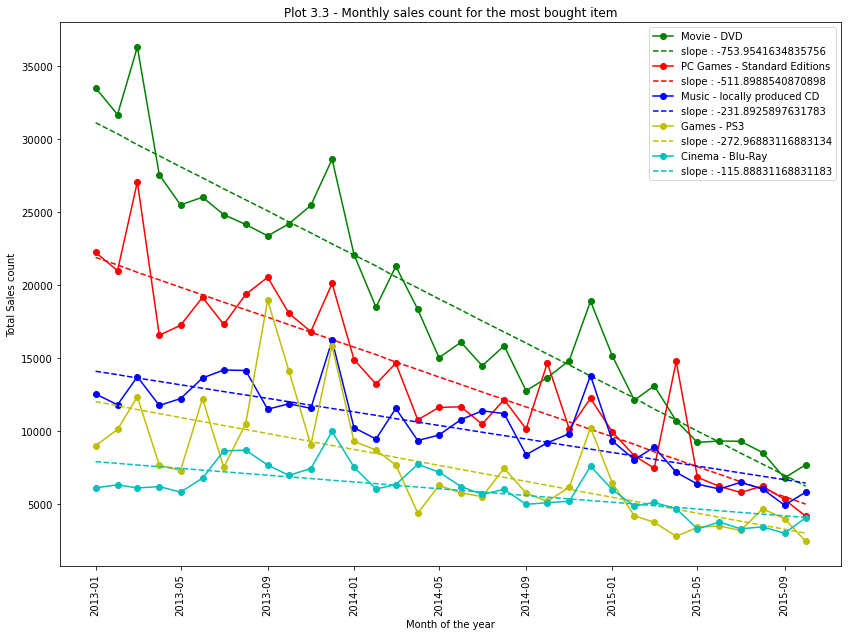

In [18]:
sales_per_category_sorted = sales_per_category.sort_values('item_cnt_day',ascending=False)
sales_per_category_sorted = sales_per_category_sorted.head(5).reset_index(drop=True)
plt.figure(figsize= (14,10))
count = 0
for index,row in sales_per_category_sorted.iterrows():
    
    item_category = row['item_category_name']
    final_sales_train_category = final_sales_train[final_sales_train['item_category_name']==item_category]
    sales_each_month_category = calculate_monthly_sale_across_years(final_sales_train_category,'item_cnt_day')
    c = ['g','r','b','y','c']
    coeffs, res, _, _, _ = np.polyfit(range(len(sales_each_month_category['item_cnt_day'].index)),sales_each_month_category['item_cnt_day'],1,full=True)
    print('The slope of the trend for the total sales count for '+ item_category + ' is : '+str(coeffs[0]))
    plt.plot(sales_each_month_category['date'],sales_each_month_category['item_cnt_day'],color=c[count],label=item_category,marker='o')
    plt.plot(sales_each_month_category['date'],[coeffs[0]*x + coeffs[1] for x in range(len(sales_each_month_category['item_cnt_day'].index))],linestyle='dashed',color=c[count],label='slope : '+str(coeffs[0]))
    count+=1
    
plt.title('Plot 3.3 - Monthly sales count for the most bought item')
plt.legend(loc='upper right')
plt.xticks(rotation='vertical')
plt.xlabel('Month of the year')
plt.ylabel('Total Sales count')
plt.show()

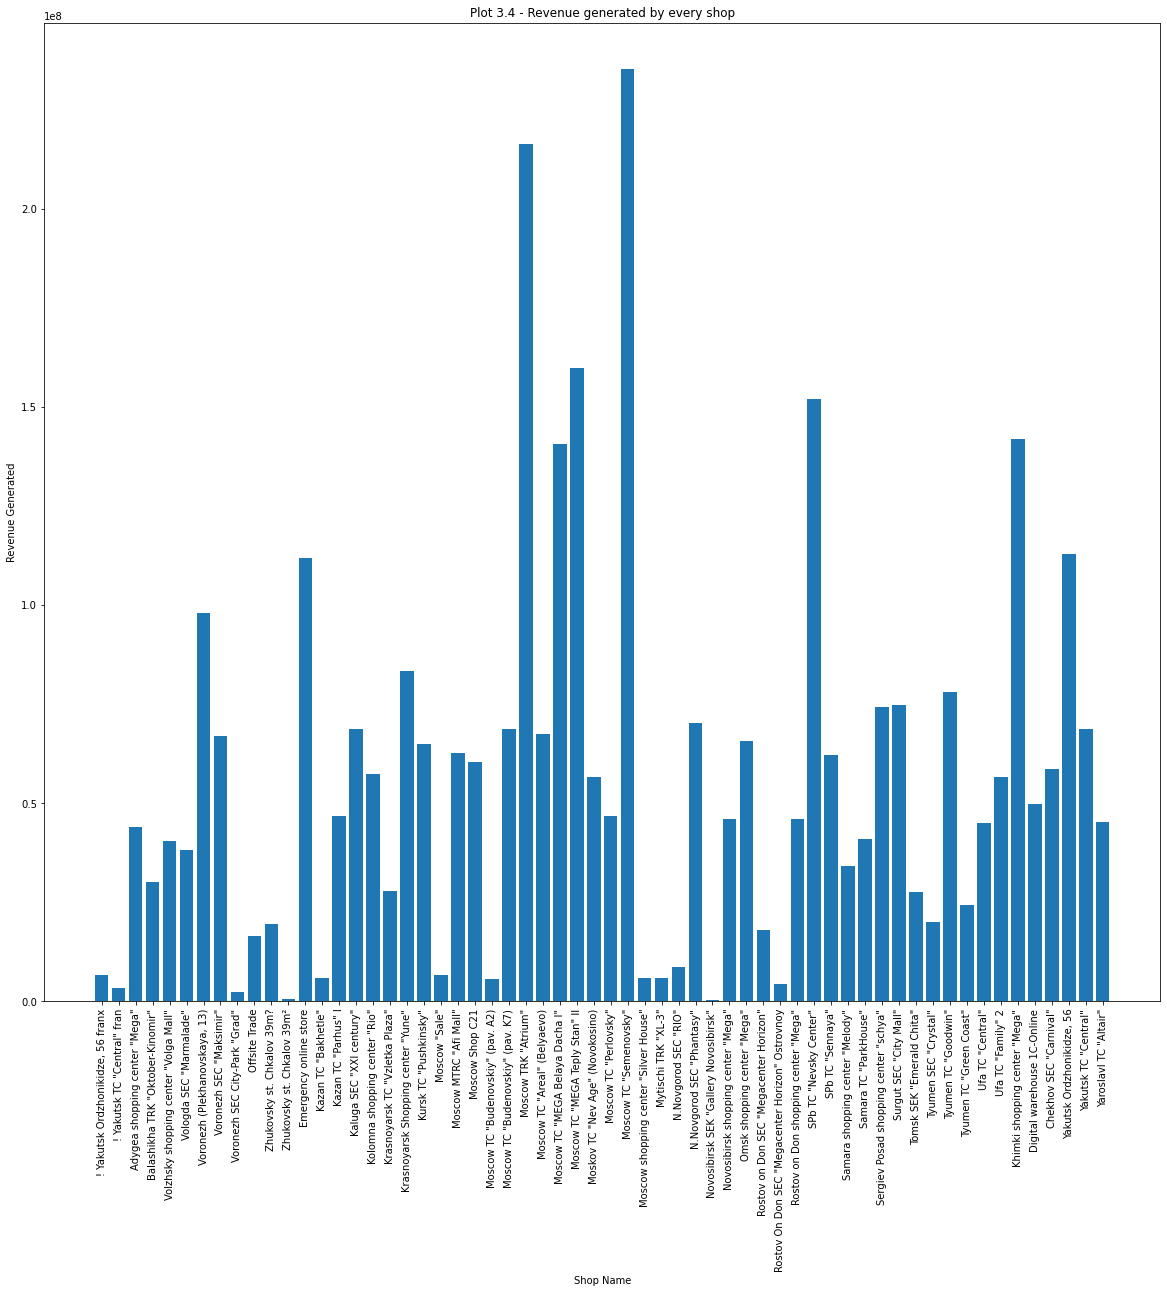

In [19]:
final_sales_train['revenue'] = final_sales_train['item_cnt_day']*final_sales_train['item_price']
revenue_per_shop = final_sales_train.groupby(by = ['shop_id'])['revenue'].sum().reset_index()
revenue_per_shop = revenue_per_shop.merge(shops, on='shop_id',how='left')

translator = Translator()
revenue_per_shop['shop_name'] = revenue_per_shop['shop_name'].apply(translator.translate, src='ru', dest='en')
revenue_per_shop['shop_name'] = revenue_per_shop['shop_name'].apply(getattr, args=('text',))

plt.figure(figsize=(20,18))
plt.title('Plot 3.4 - Revenue generated by every shop')
plt.bar(revenue_per_shop['shop_name'],revenue_per_shop['revenue'])
plt.xlabel('Shop Name')
plt.ylabel('Revenue Generated')
plt.xticks(revenue_per_shop['shop_name'], rotation='vertical')
plt.show()

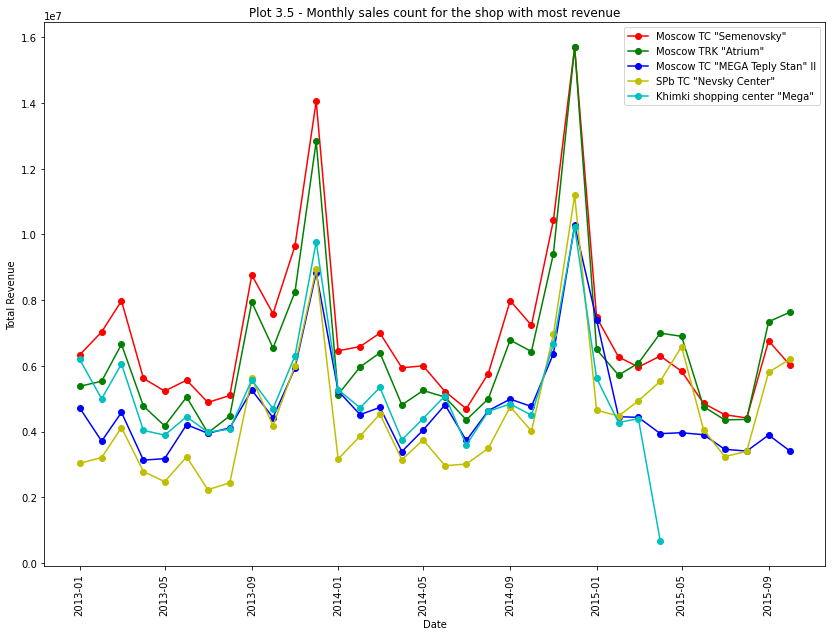

In [20]:
revenue_per_shop_sorted = revenue_per_shop.sort_values('revenue',ascending=False)
revenue_per_shop_sorted = revenue_per_shop_sorted.head(5).reset_index(drop=True)
plt.figure(figsize= (14,10))
c = ['r','g','b','y','c']
for index,row in revenue_per_shop_sorted.iterrows():
    shop_id = row['shop_id']
    shop_name = row['shop_name']
    final_sales_train_shop = final_sales_train[final_sales_train['shop_id']==shop_id]
    sales_each_month_shop = calculate_monthly_sale_across_years(final_sales_train_shop,'revenue')
    plt.plot(sales_each_month_shop['date'],sales_each_month_shop['revenue'],color=c[index],label=shop_name,marker='o')
plt.title('Plot 3.5 - Monthly sales count for the shop with most revenue')
plt.legend(loc='upper right')
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.show()

In [21]:
revenue_per_shop_sorted['city'] = revenue_per_shop_sorted['shop_name'].astype(str).apply(lambda x:x.split(' ')[0])
revenue_per_shop_sorted['city']

0    Moscow
1    Moscow
2    Moscow
3       SPb
4    Khimki
Name: city, dtype: object

Observations from plot 3.1
- The top three most bought items in the span of almost three years are Movie-DVD, PC-games standard editions, Music - locally produced CD

Observations from plot 3.2
- The most bought item Movie-DVD sales count trend is decreasing from the year 2013 to 2015. There are some spikes in sales in the month of december even though there is a  decreasing trend.
- The Movie-DVD sales count has a negative trend.

Observations from plot 3.3
- The top 5 most bought items has been plotted month wise from January 2013 to October 2015. The plot also contains the dashed lines which represents the line fit to the data points.
- From the fitted line we can observe the trend of the top five sold items. 
- The top items have more negative trend than the bottom three, which means that the top 2 item's sales count has reduced drastically than the bottom 3.

Observations from plot 3.4
- The top 3 shops with most revenue are in the city Moscow. The bottom top in the top 5 are in the city SPb and Khimki.

Observations from plot 3.5
- The top 5 shops with the most revenue are almost identical in their seasonality, where the revenue they get are highest in the month of December every year.
- The revenue average revenue they get per year for every shop is almost the same. This could have been possible by two things, either the price and item sale count remained the same every year or the price increased and the number of item sales decreased every year.  

## Part 4 - Analyze Price Change

In order to find the relationship between the price change and item sales count, we find the correlation between the sales and price change for every item,shop combination. To explain the price change of an item we use the rate of change percentage. For a particular item shop combination, if the price has not changed ever or the item sales is constant then the correlation is infinity, so we ignore such item shop combination. 

Text(0, 0.5, 'Percentage Change from original price')

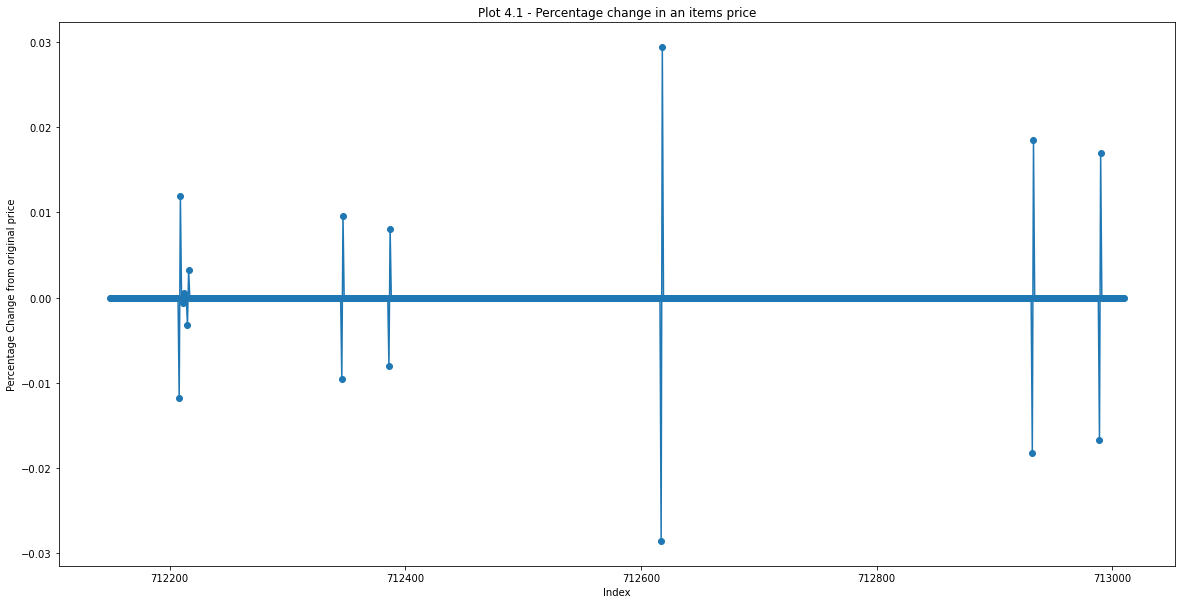

In [22]:
# Analyze price change for an item
# percentage change for the item which is sold the most in one shop
mode_item = final_sales_train['item_id'].mode().values
mode_shop = final_sales_train['shop_id'].mode().values
df_mode_item = final_sales_train[(final_sales_train['item_id']==mode_item[0])&(final_sales_train['shop_id']==mode_shop[0])]
plt.figure(figsize=(20,10))
plt.plot(df_mode_item['item_price'].pct_change(),marker='o')
plt.title('Plot 4.1 - Percentage change in an item''s price')
plt.xlabel('Index')
plt.ylabel('Percentage Change from original price')


In [23]:
# TODO: code to analyze price change
# Finding Correlation between price change and item sales count
shop_item_id = []
corr = []
item_price_variance = []
corr_price_sales = final_sales_train.groupby(['shop_id','item_id'])[['item_price','item_cnt_day']].corr().iloc[0::2,-1].reset_index()

In [24]:
item_price_var = final_sales_train.groupby(['shop_id','item_id'])['item_price'].var().reset_index()
item_price_var.rename(columns={'item_price':'item_price_var'},inplace=True)
item_cnt_day_var = final_sales_train.groupby(['shop_id','item_id'])['item_cnt_day'].var().reset_index()
item_cnt_day_var.rename(columns={'item_cnt_day':'item_cnt_day_var'},inplace=True)

In [25]:
corr_price_sales.rename(columns={'item_cnt_day':'price_sales_corr'},inplace=True)
price_sales_var = item_price_var.merge(item_cnt_day_var, on=['shop_id','item_id'],how='inner')
price_sales_corr_var = corr_price_sales.merge(price_sales_var,on=['shop_id','item_id'], how='inner')
price_sales_corr_var

,shop_id,item_id,level_2,price_sales_corr,item_price_var,item_cnt_day_var
0,0,30,item_price,NaN,0.00,5.027778
1,0,31,item_price,NaN,0.00,0.952381
2,0,32,item_price,NaN,0.00,0.272727
3,0,33,item_price,NaN,0.00,0.000000
4,0,35,item_price,NaN,0.00,0.204545
...,...,...,...,...,...,...
424118,59,22154,item_price,NaN,NaN,NaN
424119,59,22155,item_price,NaN,NaN,NaN
424120,59,22162,item_price,NaN,406.25,0.000000
424121,59,22164,item_price,NaN,750.00,0.000000


In [26]:
# deleting elements with no variance in their item_price and item_sales_count
price_sales_corr_var.dropna(subset=['price_sales_corr'],inplace=True)
price_sales_corr_var

,shop_id,item_id,level_2,price_sales_corr,item_price_var,item_cnt_day_var
10,0,51,item_price,-0.333333,2.250000,0.250000
323,0,2678,item_price,-0.166667,1642.800000,0.300000
427,0,3320,item_price,-0.163974,22780.100000,0.500000
428,0,3321,item_price,-0.184637,1209.600000,0.314286
434,0,3328,item_price,-0.133125,415.058824,2.191176
...,...,...,...,...,...,...
424092,59,22076,item_price,0.215406,24585.923050,0.926136
424094,59,22087,item_price,-0.053432,250.216450,0.758145
424095,59,22088,item_price,-0.187426,270.312144,0.676008
424096,59,22091,item_price,-0.038342,661.822660,0.876847


Text(0, 0.5, 'Number of Shop-Item Combinations')

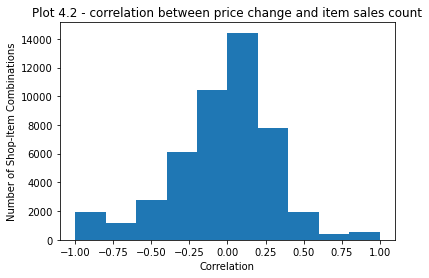

In [27]:
# histogram of the correlation between the price and the sales count per item-shop
plt.hist(price_sales_corr_var['price_sales_corr'])
plt.title('Plot 4.2 - correlation between price change and item sales count')
plt.xlabel('Correlation')
plt.ylabel('Number of Shop-Item Combinations')

Text(0, 0.5, 'Number of Shop-Item Combinations ')

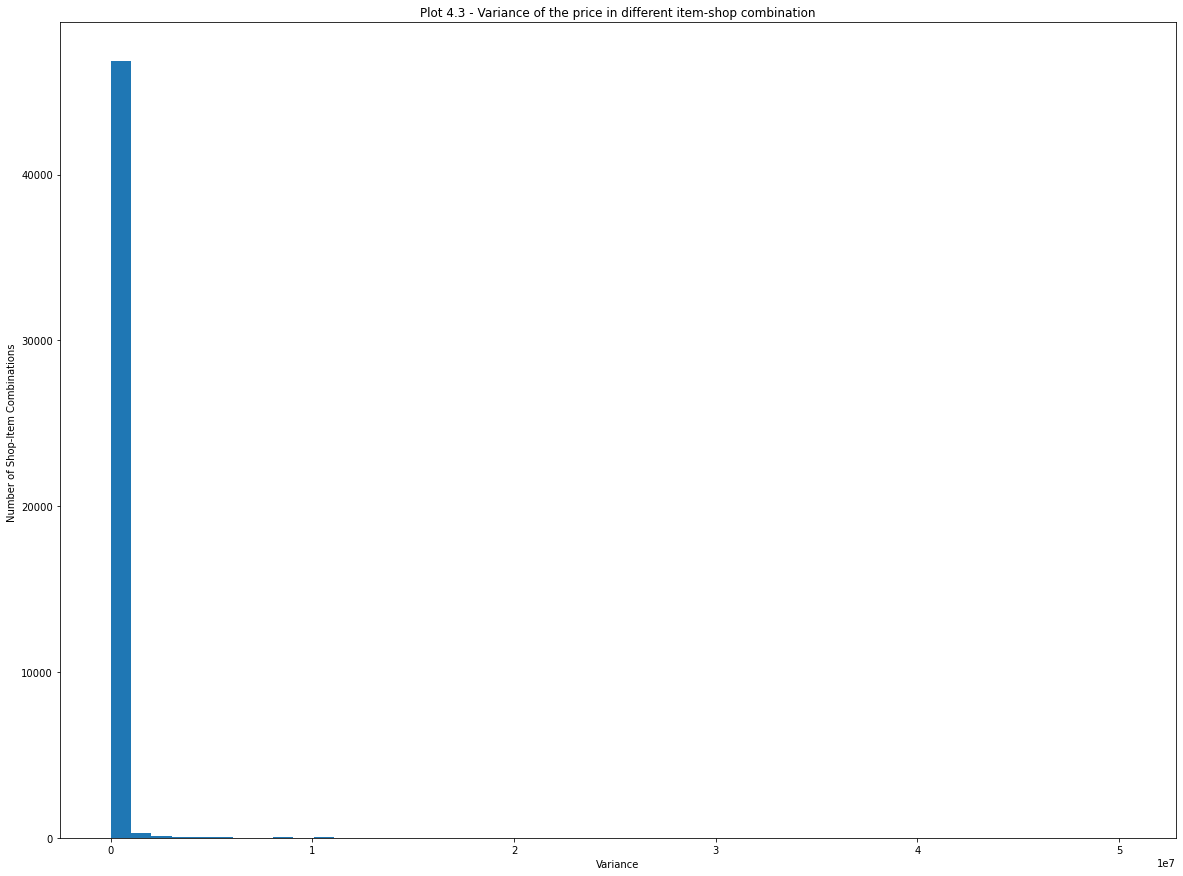

In [28]:
# histogram of the price variance in different item-shop combo

price_sales_corr_var_sorted = price_sales_corr_var.sort_values('item_price_var')
plt.figure(figsize=(20,15))
plt.hist(price_sales_corr_var_sorted['item_price_var'],bins=50)
plt.title('Plot 4.3 - Variance of the price in different item-shop combination')
plt.xlabel('Variance')
plt.ylabel('Number of Shop-Item Combinations ')

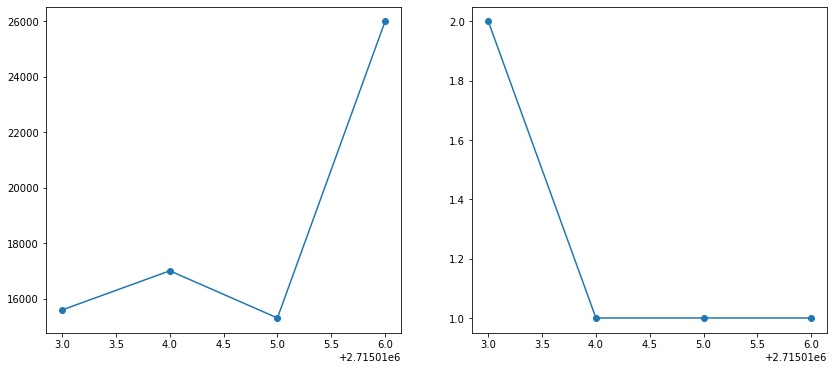

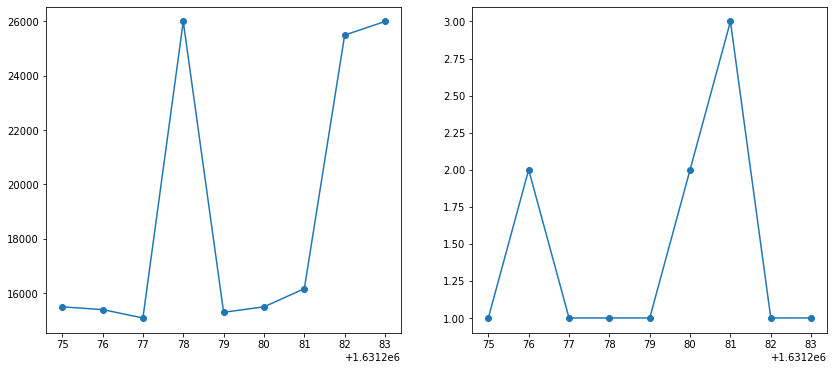

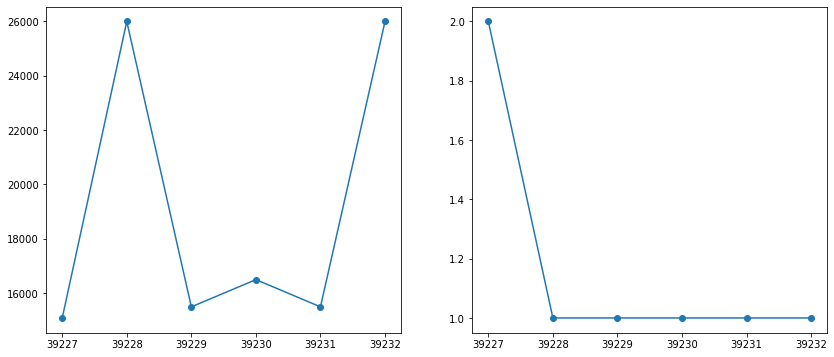

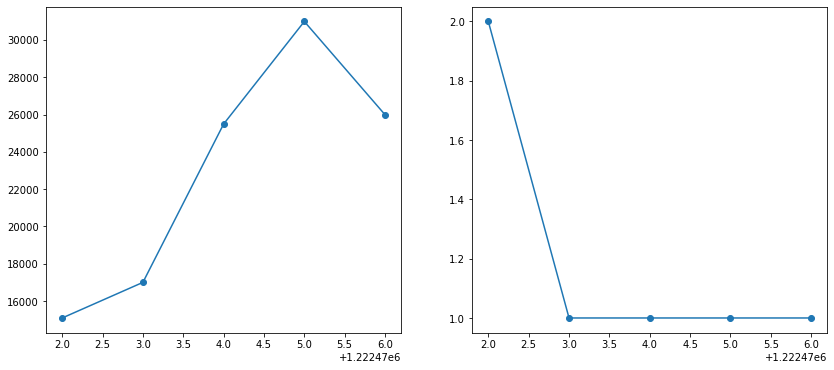

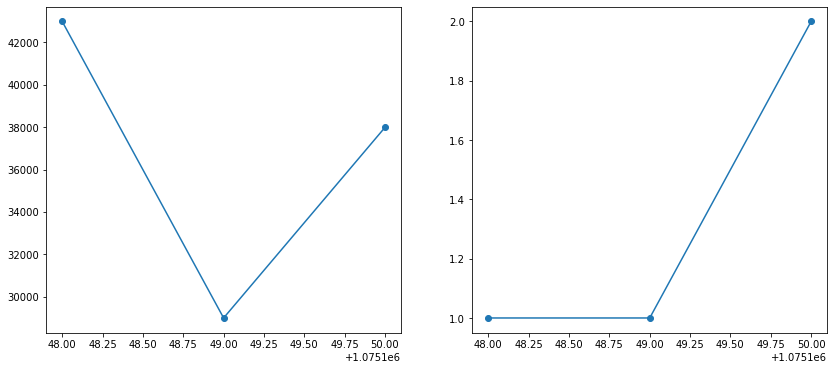

In [29]:
# plots of the item with maximum variance in their price and their corresponding item sales count

df_max_variance = price_sales_corr_var_sorted.tail(5)
for index,row in df_max_variance.iterrows():
    fig ,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
    ax1.plot(final_sales_train[(final_sales_train['item_id']==row['item_id'])&(final_sales_train['shop_id']==row['shop_id'])]['item_price'],marker='o')
    ax2.plot(final_sales_train[(final_sales_train['item_id']==row['item_id'])&(final_sales_train['shop_id']==row['shop_id'])]['item_cnt_day'],marker='o')




Observations for plot 4.1
- This block indicates the percentage change in the most bought item in any shop.
- The maximum price change for this item is either it increased 3% or decreased 3% of its original price.

Observations for plot 4.2
- The plot shows that there are item-shop combinations with negative, positive and neutral correlation. 
- But the majority of the correlations are in between 0 and 0.2. We can say that price change is slightly positively correlated.
- The plot is like a gaussian distribution with mean at 0-0.2

Observations for plot 4.3
- This plot shows that 99% of the data has a price variance between 0 and 1.
- Most of the item's price has not changed or has changed slightly.

Observation for plot 4.4
- This plot shows the top 5 items with highest price variance and their corresponding change in their sales count.
- We can see that in the top four item-shop combinations, whenever the price has increased the, the item sales has gone down.
- In the fifth item-shop combination, the price reduction did not have any effect on the sales count, but when the price increased again the item sales also when up correspondingly.

## Part 5 - Analyze Item Release Time

In [30]:
# TODO: code to analyze time since item is released
count = 0
# Days since item released in the same shop
final_sales_train['days_since_released_same_shop'] = (final_sales_train['date']-final_sales_train.groupby(['item_id','shop_id'])['date'].transform('min')).dt.days

# First ever release of the item
first_release_date_item = final_sales_train.groupby('item_id')['date'].min().reset_index()
first_release_date_item = first_release_date_item.rename(columns={'date':'first_release_date'})
final_sales_train = final_sales_train.merge(first_release_date_item, on="item_id",how='left')
final_sales_train['days_since_released_diff_shop'] = (final_sales_train['date'] - final_sales_train['first_release_date']).dt.days
final_sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,day,month,revenue,days_since_released_same_shop,first_release_date,days_since_released_diff_shop
0,2013-01-02,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Cinema - Blu-Ray,"Yaroslavl TC ""Altair""",Wednesday,January,999.0,0,2013-01-02,0
1,2013-05-16,4,59,2573,249.0,1.0,DEL REY LANA Born To Die,55,Music - locally produced CD,"Yaroslavl TC ""Altair""",Thursday,May,249.0,0,2013-01-02,134
2,2013-01-26,0,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Music - locally produced CD,"Yaroslavl TC ""Altair""",Saturday,January,399.0,17,2013-01-01,25
3,2013-01-09,0,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Music - locally produced CD,"Yaroslavl TC ""Altair""",Wednesday,January,399.0,0,2013-01-01,8
4,2013-02-24,1,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Music - locally produced CD,"Yaroslavl TC ""Altair""",Sunday,February,399.0,46,2013-01-01,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935835,2015-10-28,33,55,1819,1499.0,3.0,"Batman: Рыцарь Аркхема. Premium Edition [PC, Ц...",31,PC Games - Number,Digital warehouse 1C-Online,Wednesday,October,4497.0,0,2015-10-28,0
2935836,2015-10-29,33,55,1819,1499.0,1.0,"Batman: Рыцарь Аркхема. Premium Edition [PC, Ц...",31,PC Games - Number,Digital warehouse 1C-Online,Thursday,October,1499.0,1,2015-10-28,1
2935837,2015-10-24,33,55,2390,99.0,1.0,"Cold War [PC, Цифровая версия]",31,PC Games - Number,Digital warehouse 1C-Online,Saturday,October,99.0,0,2015-10-24,0
2935838,2015-10-01,33,55,1935,249.0,1.0,"BioShock 2. Minerva's Den (дополнение) [PC, Ци...",31,PC Games - Number,Digital warehouse 1C-Online,Thursday,October,249.0,0,2015-10-01,0


Text(0.5, 1.0, 'Plot 5.1 - The correlation of the item sales count with the number of days since the product first released in the same shop')

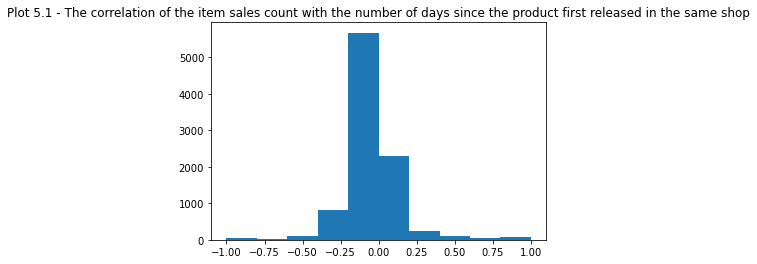

In [43]:
# The correlation of the item sales count with the number of days since the product first released in the same shop
item_id = []
corr = []
no_variance = 0
corr_item_release_same_shop = final_sales_train.groupby('item_id')[['item_cnt_day','days_since_released_same_shop']].corr().iloc[0::2,-1].reset_index()
corr_item_release_same_shop.rename(columns={'days_since_released_same_shop':'days_since_released_same_shop_corr'},inplace=True)
corr_item_release_same_shop.dropna(subset=['days_since_released_same_shop_corr'],inplace=True)
plt.hist(corr_item_release_same_shop['days_since_released_same_shop_corr'])
plt.title('Plot 5.1 - The correlation of the item sales count with the number of days since the product first released in the same shop')

Text(0.5, 1.0, 'Plot 5.2 - The correlation of the item sales count with the number of days since the item first released in a diferent shop')

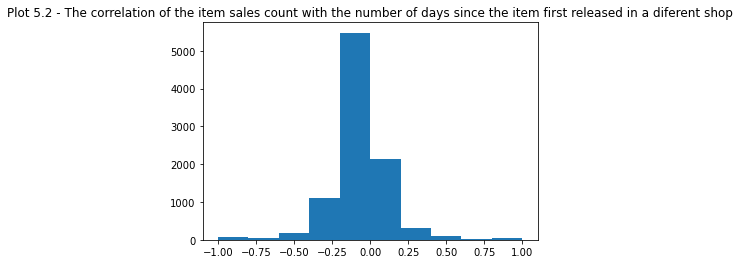

In [44]:
corr_item_release_diff_shop = final_sales_train.groupby('item_id')[['item_cnt_day','days_since_released_diff_shop']].corr().iloc[0::2,-1].reset_index()
corr_item_release_diff_shop.rename(columns={'days_since_released_diff_shop':'days_since_released_diff_shop_corr'},inplace=True)
corr_item_release_diff_shop.dropna(subset=['days_since_released_diff_shop_corr'],inplace=True)
plt.hist(corr_item_release_diff_shop['days_since_released_diff_shop_corr'])
plt.title('Plot 5.2 - The correlation of the item sales count with the number of days since the item first released in a diferent shop')

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

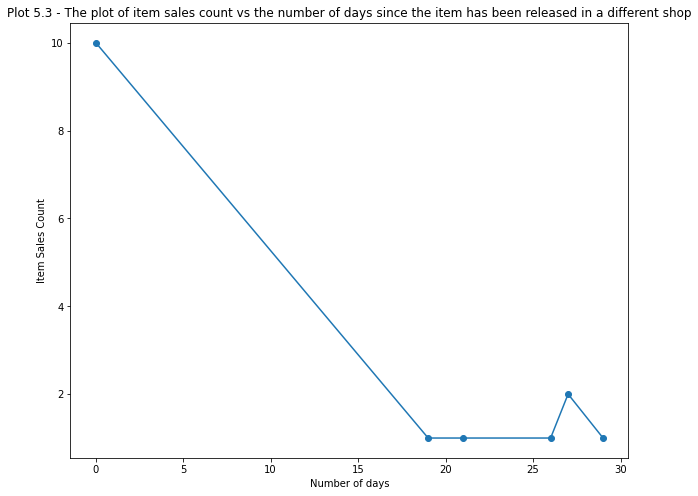

<Figure size 720x576 with 0 Axes>

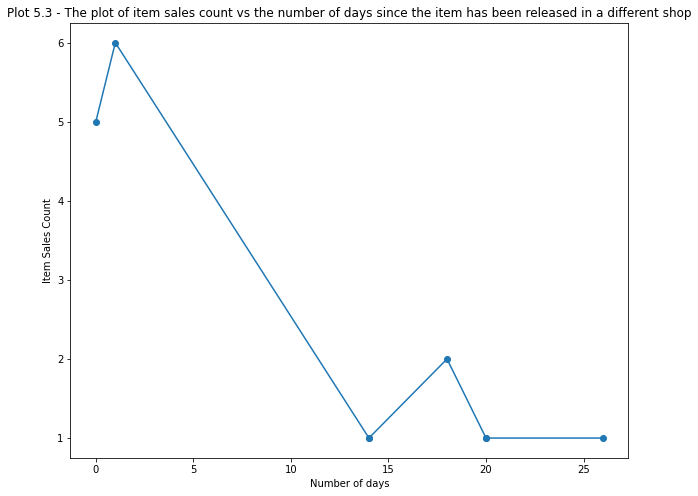

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

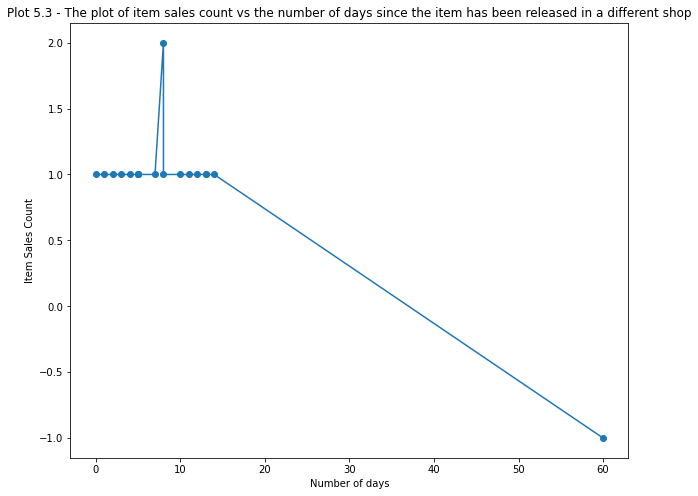

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

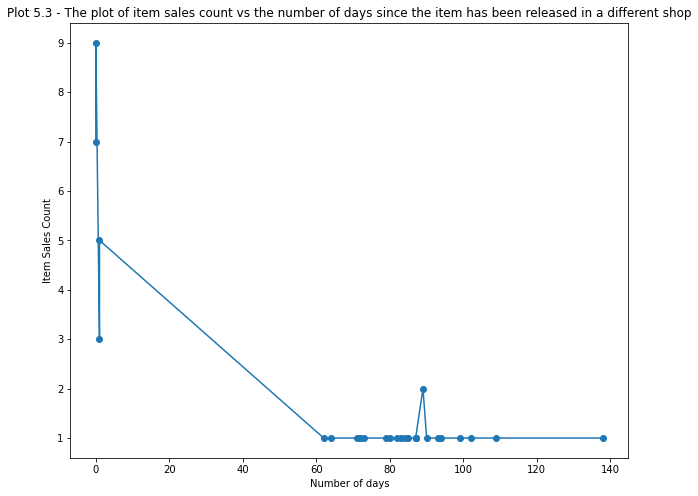

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [45]:
corr_item_release_diff_shop_sorted = corr_item_release_diff_shop.sort_values('days_since_released_diff_shop_corr')
highly_correlated = corr_item_release_diff_shop_sorted

count = 0
for index,row in highly_correlated.iterrows():
    plt.figure(figsize=(10,8))
    item_id = row['item_id']
    df = final_sales_train[final_sales_train['item_id']==item_id]
    if df.shape[0] > 5:
        count+=1
        if count==5:
            break
    else:
        continue
    df.sort_values('days_since_released_diff_shop',inplace=True)
    plt.plot(df['days_since_released_diff_shop'],df['item_cnt_day'],marker='o')
    plt.title('Plot 5.3 - The plot of item sales count vs the number of days since the item has been released in a different shop')
    plt.xlabel('Number of days')
    plt.ylabel('Item Sales Count')
    plt.show()
    

Obervations for Plot 5.1
- Majority of the items have correlation between 0 and -0.2. This means that as the number of days increases the item sales count slightly decreases.
- The item sales count decreases very slightly with the number of days since the first release in the same shop.

Observations for Plot 5.2
- Majority of the items have correlation between 0 and -0.2. This means that as the number of days increases the item sales count slightly decreases.
- The item sales count decreases very slightly with the number of days since the first release in a different shop.

Observations for Plot 5.3
- This plot show the items for which the item sales count decreases dramatically with the days since it is released in a different shop.
- These items have minimum correlation near to -1, which means that if the number of days since release in a different shop increases the item sales count decreases. 


## Part 6 - Interesting Plot

In [46]:
# TODO: code to generate the plot here.
final_sales_train['shop_name'].value_counts()
final_sales_train['city'] = final_sales_train['shop_name'].apply(lambda x:x.split(' ')[0] if x.split(' ')[0]!='!' else x.split(' ')[1])


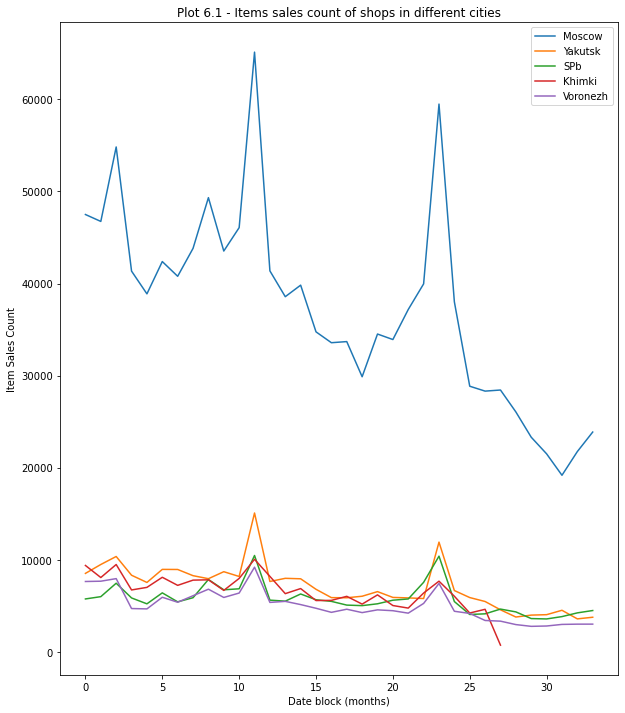

In [47]:
city_sales = final_sales_train.groupby(['city','date_block_num'])['item_cnt_day'].sum().reset_index()
city_sales.rename(columns={'item_cnt_day':'item_cnt_month'},inplace=True)
city_max_sales_sorted = city_sales.groupby('city')['item_cnt_month'].sum().reset_index().sort_values('item_cnt_month',ascending=False).head()
city_max_sales_sorted
plt.figure(figsize=(10,12))
for i in city_max_sales_sorted['city'].unique():
    df = city_sales[city_sales['city'] == i]
    plt.plot(df['date_block_num'],df['item_cnt_month'],label=i)
plt.legend(loc = 'upper right')
plt.title('Plot 6.1 - Items sales count of shops in different cities')
plt.xlabel('Date block (months)')
plt.ylabel('Item Sales Count')
plt.show()

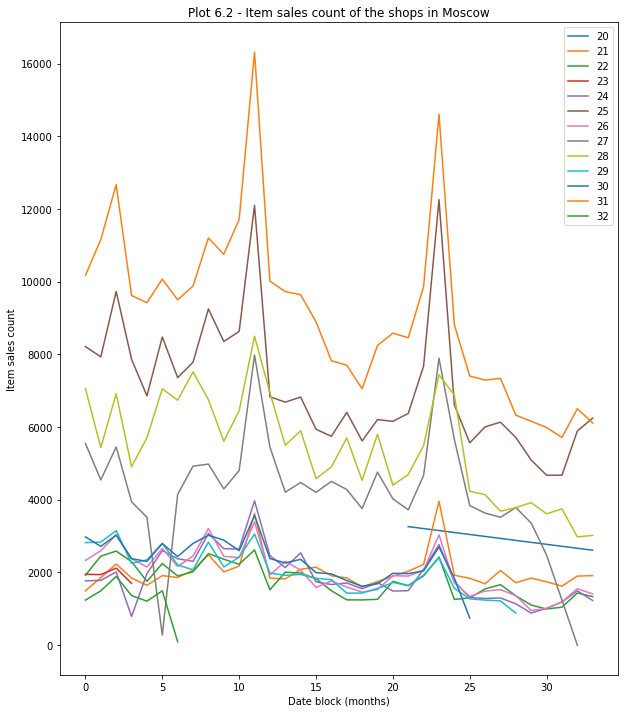

In [48]:
# shops in moscow
moscow_sales = final_sales_train[final_sales_train['city']=='Moscow']
moscow_sales_item = moscow_sales.groupby(['shop_id','date_block_num'])['item_cnt_day'].sum().reset_index()
moscow_sales_item.rename(columns={'item_cnt_day':'item_cnt_month'},inplace=True)
# moscow_sales_item.groupby(['shop_id'])['item_cnt_month'].sum().reset_index()
plt.figure(figsize=(10,12))
for i in moscow_sales_item['shop_id'].unique():
    df = moscow_sales_item[moscow_sales_item['shop_id'] == i]
    plt.plot(df['date_block_num'],df['item_cnt_month'],label=i)
plt.legend(loc = 'upper right')
plt.title('Plot 6.2 - Item sales count of the shops in Moscow')
plt.xlabel('Date block (months)')
plt.ylabel('Item sales count')
plt.show()

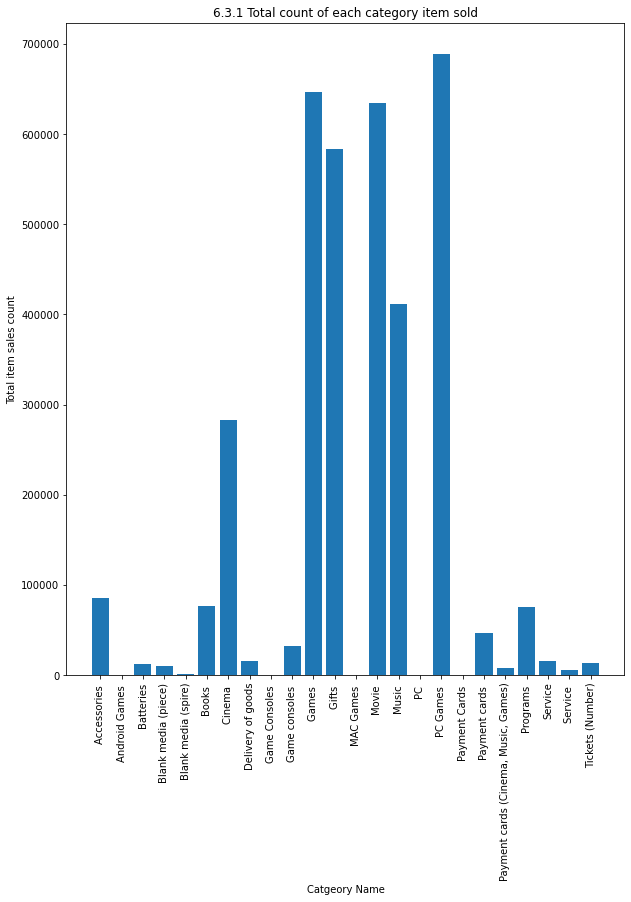

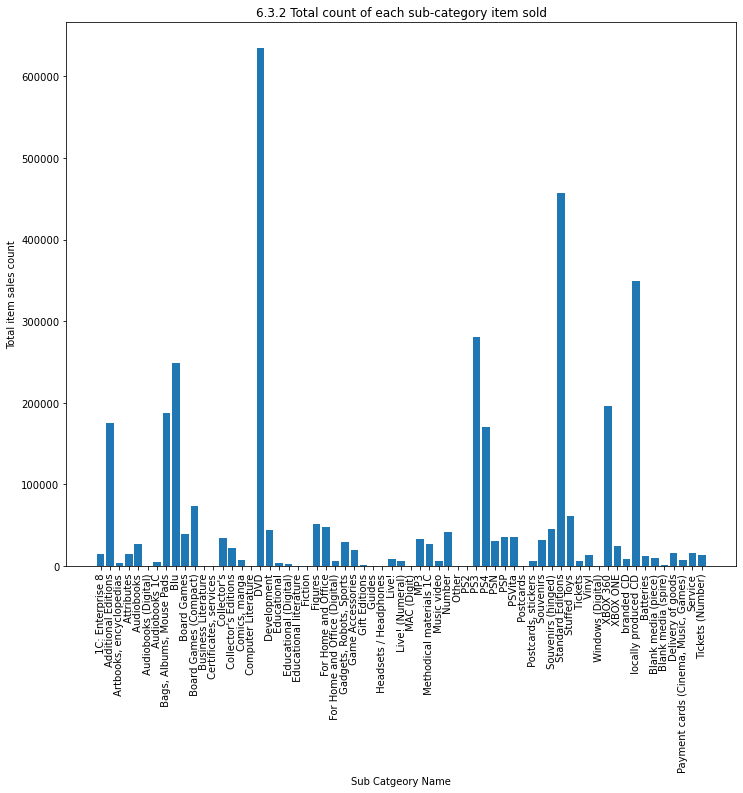

In [49]:
final_sales_train['category_type'] = final_sales_train['item_category_name'].astype(str).apply(lambda x:x.split('-')[0])
final_sales_train['category_sub_type'] = final_sales_train['item_category_name'].astype(str).apply(lambda x:x.split('-')[1] if len(x.split('-'))>1 else x)
# final_sales_train['']
category = final_sales_train.groupby('category_type')['item_cnt_day'].sum().reset_index()
plt.figure(figsize=(10,12))
plt.bar(category['category_type'],category['item_cnt_day'])
plt.xticks(rotation=90)
plt.title('6.3.1 Total count of each category item sold')
plt.xlabel('Catgeory Name')
plt.ylabel('Total item sales count')
plt.show()

category_sub_type = final_sales_train.groupby('category_sub_type')['item_cnt_day'].sum().reset_index()
plt.figure(figsize=(12,10))
plt.bar(category_sub_type['category_sub_type'],category_sub_type['item_cnt_day'])
plt.xticks(rotation=90)
plt.title('6.3.2 Total count of each sub-category item sold')
plt.xlabel('Sub Catgeory Name')
plt.ylabel('Total item sales count')
plt.show()
plt.show()




The new observation was that after the translation of the shop name, the first part of the shop name contains the city name. And the city name helps a lot in observing the pattern in the item sales count over a time period. We can get lot of insights from the city name this feature has been included in the model for forecasting.

Observations for plot 6.1
- The total sales count per month in moscow is very much greater than the total sales count per month in every other city in Russia.
- It might be because of the population in Moscow is more than that of any other city in Russia.
- An item in the test set which was sold more in the moscow city is defintely going to be sold more than an item in any other city.
- All the other major cities in the top 5 total sales count have similar sales during the entire span of almost three years.

Observations for plot 6.2
- Four shops in moscow seem to dominate the sales of the items. They might be some big malls in the moscow city.
- All the other shops in Moscow have almost the same amount of sales through out the three years.

The second new observation was that the item catgeory name contains item category type at the first part of its string and it contains category sub-type in the second part of its string. This category type and category subtype is very important in forecasting the item sales and has been included in the model.

Observations for plot 6.3
- The 6.3.1 shows the total sales count of each category type.
- The top 4 items bought in the span of almost three years was Games, PC Games, Movies and Gifts.
- The 6.3.2 shows the total sales count of each sub-category type.
- The major sub category sold is the DVD. It could be either of the games DVD or PC games DVD or Movies DVD.



## Part 7 - Prediction Model

In [50]:
# Grouping the training set with item_id,shop_id,date_block_num as we have to forecast the sales count for november using item_id and shop_id

final_sales_train['year'] = pd.DatetimeIndex(final_sales_train['date']).year
train = final_sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'mean', 'item_price':'mean'}).reset_index()
train.rename(columns={'item_cnt_day':'item_cnt_month'},inplace=True)
train.sort_values('date_block_num',inplace=True)


In [51]:
# Load the test set and concat it with the training set so that we can add lag features to the test set along with the training set 

test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
train = train[['item_id','item_price','shop_id','date_block_num','item_cnt_month']]
test['date_block_num'] = 34
test['item_cnt_month'] = 0
del test['ID']

train_test = pd.concat([train,test],axis=0)
train_test['item_price'] = train_test['item_price'].fillna(0)

# Creating Lag features

In [52]:
# Creating lag feature of the item price per month for every shop-item pair for the past 12 months

df_groups = train_test.groupby(by = ['shop_id', 'item_id', 'date_block_num'])
for i in range(1,13):
    df = df_groups.agg({'item_price':'mean'}).reset_index()
    df['date_block_num'] += i
    df.rename(columns={'item_price': 'item_price_lag_'+str(i)}, inplace=True)
    train_test = train_test.merge(df, on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
    train_test = train_test.fillna(0)
train_test

,item_id,item_price,shop_id,date_block_num,item_cnt_month,item_price_lag_1,item_price_lag_2,item_price_lag_3,item_price_lag_4,item_price_lag_5,item_price_lag_6,item_price_lag_7,item_price_lag_8,item_price_lag_9,item_price_lag_10,item_price_lag_11,item_price_lag_12
0,32,221.0,0,0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18783,179.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,18789,149.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18797,248.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18822,149.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823317,18454,0.0,45,34,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,199.0,199.0,199.0,199.0,0.0
1823318,16188,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1823319,15757,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,199.0,199.0,0.0,0.0
1823320,19648,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Creating lag feature of the item sales count per month for every item for the past 12 months

df_groups = train_test.groupby(by = ['item_id', 'date_block_num'])
for i in range(1,13):
    df = df_groups.agg({'item_cnt_month':'mean'}).reset_index()
    df['date_block_num'] += i
    df.rename(columns={'item_cnt_month': 'item_cnt_item_lag_'+str(i)}, inplace=True)
    train_test = train_test.merge(df, on = ['item_id', 'date_block_num'], how = 'left')
    train_test = train_test.fillna(0)      
train_test

,item_id,item_price,shop_id,date_block_num,item_cnt_month,item_price_lag_1,item_price_lag_2,item_price_lag_3,item_price_lag_4,item_price_lag_5,...,item_cnt_item_lag_3,item_cnt_item_lag_4,item_cnt_item_lag_5,item_cnt_item_lag_6,item_cnt_item_lag_7,item_cnt_item_lag_8,item_cnt_item_lag_9,item_cnt_item_lag_10,item_cnt_item_lag_11,item_cnt_item_lag_12
0,32,221.0,0,0,1.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,18783,179.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,18789,149.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,18797,248.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,18822,149.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823317,18454,0.0,45,34,0.0,99.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.024691,1.030702,1.068373,1.027941,1.101020,0.0
1823318,16188,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1823319,15757,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,0.925926,1.000000,1.0
1823320,19648,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.166667,0.0


In [54]:
# Creating lag feature of the item sales count per month for every shop for the past 12 months

df_groups = train_test.groupby(by = ['shop_id', 'date_block_num'])
for i in range(1,13):
    df = df_groups.agg({'item_cnt_month':'mean'}).reset_index()
    df['date_block_num'] += i
    df.rename(columns={'item_cnt_month': 'item_cnt_shop_lag_'+str(i)}, inplace=True)
    train_test = train_test.merge(df, on = ['shop_id', 'date_block_num'], how = 'left')
    train_test = train_test.fillna(0)      
train_test


,item_id,item_price,shop_id,date_block_num,item_cnt_month,item_price_lag_1,item_price_lag_2,item_price_lag_3,item_price_lag_4,item_price_lag_5,...,item_cnt_shop_lag_3,item_cnt_shop_lag_4,item_cnt_shop_lag_5,item_cnt_shop_lag_6,item_cnt_shop_lag_7,item_cnt_shop_lag_8,item_cnt_shop_lag_9,item_cnt_shop_lag_10,item_cnt_shop_lag_11,item_cnt_shop_lag_12
0,32,221.0,0,0,1.5,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,18783,179.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,18789,149.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,18797,248.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,18822,149.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823317,18454,0.0,45,34,0.0,99.0,0.0,0.0,0.0,0.0,...,1.048416,1.026852,1.044395,1.063318,1.091539,1.041253,1.060254,1.033187,1.043762,1.107548
1823318,16188,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,1.048416,1.026852,1.044395,1.063318,1.091539,1.041253,1.060254,1.033187,1.043762,1.107548
1823319,15757,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,1.048416,1.026852,1.044395,1.063318,1.091539,1.041253,1.060254,1.033187,1.043762,1.107548
1823320,19648,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,1.048416,1.026852,1.044395,1.063318,1.091539,1.041253,1.060254,1.033187,1.043762,1.107548


In [55]:
# Creating lag feature of the item price per month for every shop for the past 12 months

df_groups = train_test.groupby(by = ['shop_id', 'date_block_num'])
for i in range(1,13):
    df = df_groups.agg({'item_price':'mean'}).reset_index()
    df['date_block_num'] += i
    df.rename(columns={'item_price': 'item_price_shop_lag_'+str(i)}, inplace=True)
    train_test = train_test.merge(df, on = ['shop_id', 'date_block_num'], how = 'left')
    train_test = train_test.fillna(0)      
train_test


,item_id,item_price,shop_id,date_block_num,item_cnt_month,item_price_lag_1,item_price_lag_2,item_price_lag_3,item_price_lag_4,item_price_lag_5,...,item_price_shop_lag_3,item_price_shop_lag_4,item_price_shop_lag_5,item_price_shop_lag_6,item_price_shop_lag_7,item_price_shop_lag_8,item_price_shop_lag_9,item_price_shop_lag_10,item_price_shop_lag_11,item_price_shop_lag_12
0,32,221.0,0,0,1.5,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,18783,179.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,18789,149.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,18797,248.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4,18822,149.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823317,18454,0.0,45,34,0.0,99.0,0.0,0.0,0.0,0.0,...,890.696962,851.711373,1193.233605,1033.166006,1083.814031,947.089401,1169.448516,990.10473,1205.686989,1188.125129
1823318,16188,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,890.696962,851.711373,1193.233605,1033.166006,1083.814031,947.089401,1169.448516,990.10473,1205.686989,1188.125129
1823319,15757,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,890.696962,851.711373,1193.233605,1033.166006,1083.814031,947.089401,1169.448516,990.10473,1205.686989,1188.125129
1823320,19648,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,890.696962,851.711373,1193.233605,1033.166006,1083.814031,947.089401,1169.448516,990.10473,1205.686989,1188.125129


In [56]:
# Creating lag feature of the item price per month for every item for the past 12 months

df_groups = train_test.groupby(by = ['item_id', 'date_block_num'])
for i in range(1,13):
    df = df_groups.agg({'item_price':'mean'}).reset_index()
    df['date_block_num'] += i
    df.rename(columns={'item_price': 'item_price_item_lag_'+str(i)}, inplace=True)
    train_test = train_test.merge(df, on = ['item_id', 'date_block_num'], how = 'left')
    train_test = train_test.fillna(0)      
train_test


,item_id,item_price,shop_id,date_block_num,item_cnt_month,item_price_lag_1,item_price_lag_2,item_price_lag_3,item_price_lag_4,item_price_lag_5,...,item_price_item_lag_3,item_price_item_lag_4,item_price_item_lag_5,item_price_item_lag_6,item_price_item_lag_7,item_price_item_lag_8,item_price_item_lag_9,item_price_item_lag_10,item_price_item_lag_11,item_price_item_lag_12
0,32,221.0,0,0,1.5,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,18783,179.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,18789,149.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,18797,248.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,18822,149.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823317,18454,0.0,45,34,0.0,99.0,0.0,0.0,0.0,0.0,...,99.000000,99.0,98.944444,199.000000,195.703704,194.315789,193.764706,196.284804,196.880952,0.0
1823318,16188,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1823319,15757,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,229.000000,229.0,229.000000,203.444444,199.000000,199.000000,189.555556,189.555556,199.000000,199.0
1823320,19648,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,94.166667,99.0,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,0.0


In [57]:
# Creating lag feature of the item sales count per month for every shop-item for the past 12 months

df_groups = train_test.groupby(by = ['item_id','shop_id','date_block_num'])
for i in range(1,13):
    df = df_groups.agg({'item_cnt_month':'mean'}).reset_index()
    df['date_block_num'] += i
    df.rename(columns={'item_cnt_month': 'item_cnt_lag_'+str(i)}, inplace=True)
    train_test = train_test.merge(df, on = ['item_id','shop_id', 'date_block_num'], how = 'left')
    train_test = train_test.fillna(0)      
train_test


,item_id,item_price,shop_id,date_block_num,item_cnt_month,item_price_lag_1,item_price_lag_2,item_price_lag_3,item_price_lag_4,item_price_lag_5,...,item_cnt_lag_3,item_cnt_lag_4,item_cnt_lag_5,item_cnt_lag_6,item_cnt_lag_7,item_cnt_lag_8,item_cnt_lag_9,item_cnt_lag_10,item_cnt_lag_11,item_cnt_lag_12
0,32,221.0,0,0,1.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18783,179.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,18789,149.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18797,248.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18822,149.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823317,18454,0.0,45,34,0.0,99.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
1823318,16188,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1823319,15757,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1823320,19648,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# Creating lag feature of the mean item sales count per month for all the transactions in that monthirrespective of item_id

df_groups = train_test.groupby(by = ['date_block_num'])
for i in range(1,2):
    df = df_groups.agg({'item_cnt_month':'mean'}).reset_index()
    df['date_block_num'] += i
    df.rename(columns={'item_cnt_month': 'item_cnt_avg_lag_'+str(i)}, inplace=True)
    train_test = train_test.merge(df, on = ['date_block_num'], how = 'left')
    train_test = train_test.fillna(0)      
train_test


,item_id,item_price,shop_id,date_block_num,item_cnt_month,item_price_lag_1,item_price_lag_2,item_price_lag_3,item_price_lag_4,item_price_lag_5,...,item_cnt_lag_4,item_cnt_lag_5,item_cnt_lag_6,item_cnt_lag_7,item_cnt_lag_8,item_cnt_lag_9,item_cnt_lag_10,item_cnt_lag_11,item_cnt_lag_12,item_cnt_avg_lag_1
0,32,221.0,0,0,1.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,18783,179.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,18789,149.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,18797,248.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,18822,149.0,37,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823317,18454,0.0,45,34,0.0,99.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.121179
1823318,16188,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.121179
1823319,15757,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.121179
1823320,19648,0.0,45,34,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.121179


In [59]:
# generating 1 revenue lag for feature for every item, every shop, every item-shop  
train_test['revenue_1_lag'] = train_test['item_cnt_lag_1']*train_test['item_price_lag_1']
train_test['revenue_item_lag_1'] = train_test['item_cnt_item_lag_1']*train_test['item_price_item_lag_1']
train_test['revenue_shop_lag_1'] = train_test['item_cnt_shop_lag_1']*train_test['item_price_shop_lag_1']

In [60]:
# replacing all the NA's created due to the lags with zero, as they are prices and item sales count. 
train_test = train_test.fillna(0)

In [61]:
# filter all the rows where the items are sold only once in the whole three years 
train_test = train_test.groupby('item_id').filter(lambda x: len(x) > 1)

In [62]:
# Get the category type and the subcategory type from the item_category_name, label encode them as they are categorical variables.
items_categories['category_type'] = items_categories['item_category_name'].astype(str).apply(lambda x:x.split('-')[0])
items_categories['category_sub_type'] = items_categories['item_category_name'].astype(str).apply(lambda x:x.split('-')[1] if len(x.split('-'))>1 else x)
items_categories['category_type'] = items_categories['category_type'].astype(str).apply(lambda x:x.split('(')[0].rstrip() if '(' in x else x)

category_type_encoder = LabelEncoder()
category_subtype_encoder = LabelEncoder()
items_categories['category_type'] = category_type_encoder.fit_transform(items_categories['category_type'])
items_categories['category_sub_type'] = category_subtype_encoder.fit_transform(items_categories['category_sub_type'])

In [63]:
# add features such as month, year and number of days in that corresponding month
train_test['month'] = train_test['date_block_num']%12
train_test['year'] = (train_test['date_block_num']/12+2013).astype(int)
train_test['days'] = train_test['month'].map(pd.Series([31,28,31,30,31,30,31,31,30,31,30,31]))

In [64]:
# Merge the category and subcategory type to the main dataset and remove the unncessary features from the dataset
train_test = train_test.merge(items,on='item_id',how='left')
train_test.drop(columns=['item_name'],inplace=True)

train_test = train_test.merge(items_categories,on='item_category_id',how='left')
train_test.drop(columns=['item_category_name'],inplace=True)

In [65]:
# add city feature which can be extracted from the shop name, label encode it, merge it with the dataset and drop the uncessary features

shops['city'] = shops['shop_name'].apply(lambda x:x.split(' ')[0] if x.split(' ')[0]!='!' else x.split(' ')[1])
city_encoder = LabelEncoder()
shops['city'] = city_encoder.fit_transform(shops['city'])

train_test = train_test.merge(shops,on='shop_id',how='left')
train_test.drop(columns=['shop_name'],inplace=True)

In [66]:
# Apply min-max scaling for all the numerical features, to normalise every feature to the range 0-1.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns = train_test.columns
features_scaling = []
for i in columns:
    if 'price' in i:
        features_scaling.append(i)
    elif 'cnt' in i and i!='item_cnt_month':
        features_scaling.append(i)
    elif 'revenue' in i:
        features_scaling.append(i)
train_test[features_scaling] = scaler.fit_transform(train_test[features_scaling])



In [67]:
# Seperate the train, validation data delete the item_price, item_cnt_month from each of the input features
# Train data will be from January 2014 till september 2015. # we take the october month as the validation set to check the performance of the various festures we engineered.

train_x = train_test[(train_test['date_block_num']<33) & (train_test['date_block_num']>11)]
train_y = train_x['item_cnt_month'].clip(0,20)
del train_x['item_cnt_month']
del train_x['item_price']

val_x = train_test[train_test['date_block_num']==33]
val_y = val_x['item_cnt_month'].clip(0,20)
del val_x['item_price']
del val_x['item_cnt_month']

test_x = train_test[train_test['date_block_num']==34]
test_y = test_x['item_cnt_month'].clip(0,20)
del test_x['item_price']
del test_x['item_cnt_month']

In [70]:
# Train a Linear regression model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_x,train_y)
pred = lr.predict(val_x)
print(np.sqrt(mean_squared_error(val_y,pred)))

0.6316898641253134


In [105]:
# Train a gradient boosting model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=3, random_state=0, loss='ls')
reg = model.fit(train_x,train_y)
pred = reg.predict(test_x)

In [74]:
# Train a xgboost model
xgb = XGBRegressor(objective='reg:squarederror',
    n_estimators=1000,
    max_depth=8,
    reg_alpha=0.1,
    reg_lambda=2,
    eta=0.2,
    tree_method='gpu_hist')

xgb.fit(train_x,train_y,eval_metric="rmse",
        eval_set=[(train_x, train_y), (val_x, val_y)],
        verbose=True,
        early_stopping_rounds = 10)

[0]	validation_0-rmse:0.65102	validation_1-rmse:0.81392
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.57267	validation_1-rmse:0.74877
[2]	validation_0-rmse:0.51689	validation_1-rmse:0.70404
[3]	validation_0-rmse:0.47274	validation_1-rmse:0.67347
[4]	validation_0-rmse:0.44320	validation_1-rmse:0.65095
[5]	validation_0-rmse:0.42204	validation_1-rmse:0.63743
[6]	validation_0-rmse:0.40728	validation_1-rmse:0.62818
[7]	validation_0-rmse:0.39648	validation_1-rmse:0.62321
[8]	validation_0-rmse:0.38876	validation_1-rmse:0.61980
[9]	validation_0-rmse:0.38314	validation_1-rmse:0.62002
[10]	validation_0-rmse:0.37832	validation_1-rmse:0.62284
[11]	validation_0-rmse:0.37377	validation_1-rmse:0.62927
[12]	validation_0-rmse:0.37114	validation_1-rmse:0.63336
[13]	validation_0-rmse:0.36946	validation_1-rmse:0.63451
[14]	validation_0-rmse:0.36718	validation_1-rmse:0.63

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.1, reg_lambda=2, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [75]:
# After validation, for actual forcasting take the training set from January 2014 to October 2015. And we will forecast for the month of November.

train_x = train_test[(train_test['date_block_num']<34) & (train_test['date_block_num']>11)]
train_y = train_x['item_cnt_month'].clip(0,20)
del train_x['item_cnt_month']
del train_x['item_price']

test_x = train_test[train_test['date_block_num']==34]
test_y = test_x['item_cnt_month'].clip(0,20)
del test_x['item_price']
del test_x['item_cnt_month']

xgb = XGBRegressor(objective='reg:squarederror',
    n_estimators=1,
    max_depth=8,
    reg_alpha=0.1,
    reg_lambda=2,
    eta=0.2,
    tree_method='gpu_hist')

xgb.fit(train_x,train_y,eval_metric="rmse",
        eval_set=[(train_x, train_y)],
        verbose=True,
        early_stopping_rounds = 10)

[0]	validation_0-rmse:0.65730
Will train until validation_0-rmse hasn't improved in 10 rounds.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.200000003, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=1, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.1, reg_lambda=2, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [102]:
pred = xgb.predict(test_x)
testresult = pd.DataFrame({'item_cnt_month':pred})
testresult['ID'] = testresult.index
testresult.to_csv('Submission12.csv',index=None)

Regression Model

The main concept used for modelling this problem is to convert a time series prediction into a machine learning prediction is to introduce lag features for the variable which needs to be forecasted by the ML model. Lag features for variables are variables which contain data from previous time stamps. Every row contains data of a variable and previous n occurences of that variable.

The steps I followed for the predicting model is:-
- Grouping the training set with item_id,shop_id,date_block_num as we have to forecast the sales count for november using item_id and shop_id
- Load the test set and concat it with the training set so that we can add lag features to the test set along with the training set 
- Creating lag feature of the item price per month for every shop-item pair for the past 12 months
- Creating lag feature of the item sales count per month for every item for the past 12 months
- Creating lag feature of the item sales count per month for every shop for the past 12 months
- Creating lag feature of the item price per month for every shop for the past 12 months
- Creating lag feature of the item price per month for every item for the past 12 months
- Creating lag feature of the item sales count per month for every shop-item for the past 12 months
- Creating lag feature of the mean item sales count per month for all the transactions in that monthirrespective of item_id
- generating 1 revenue lag for feature for every item, every shop, every item-shop  
- replacing all the NA's created due to the lags with zero, as they are prices and item sales count. 
- filter all the rows where the items are sold only once in the whole three years 
- Get the category type and the subcategory type from the item_category_name, label encode them as they are categorical variables.
- add features such as month, year and number of days in that corresponding month
- Merge the category and subcategory type to the main dataset and remove the unncessary features from the dataset
- add city feature which can be extracted from the shop name, label encode it, merge it with the dataset and drop the uncessary features
- Apply min-max scaling for all the numerical features, to normalise every feature to the range 0-1.
- Seperate the train, validation data delete the item_price, item_cnt_month from each of the input features
- Train data will be from January 2014 till september 2015. # we take the october month as the validation set to check the performance of the various festures we engineered.
- Train a Linear regression model
- Train a gradient boosting model
- Train a xgboost model
- After validation, for actual forcasting take the training set from January 2014 to October 2015. And we will forecast for the month of November.


The features I included in the model are as follows:-
- Month of the item sale
- Number of days in the month of the sale
- Year of the sale
- City in which the item was sold
- Category type of the item
- Category subtype of the item
- Category ID of the item
- Item ID
- Shop ID
- Date Block Number (The month in which the item was sold)
- Lag Features
    - Avergae item sales count per month lag for every shop-item combination for the past 12 months
    - Avergae item sales count per month lag for every shop for the past 12 months
    - Avergae item sales count per month lag for every item for the past 12 months
    - Avergae item price count per month lag for every shop-item combination for the past 12 months
    - Avergae item price count per month lag for every shop for the past 12 months
    - Avergae item price count per month lag for every item for the past 12 months

Inorder to select these features, I used the 2015 october month as the validation set. I selected the features which performed better on the validation dataset and used them for the test set. I used the root mean square error as the metric, which is a common metric used in regression problems.

After the feature engineering, inorder to train the model with the train dataset, we ignore the first 12 months data because most of the features we have taken in our model are lag features for 12 months. Due to this, the first 12 months data will mostly be NAN and as they are item price and item counts, we can replace them with zero. As most of the features will contain zero for the first 12 months, we remove it before training the model.

I built three models for prediction which are as follows :
- Linear Regression 
- Gradient Boosting Regression
- Extreme Gradient Boosting or XGBoost

XGBoost gave me the highest score in the public leaderboard.
